# (E14) 프로젝트 : 폐렴 진단기 성능개선

X-RAY 사진을 판독하여 폐렴을 진단하는 프로젝트입니다. 의료영상을 분석하는 것은 일반적인 이미지를 분석하는 것과 다음과 같은 차이가 있습니다.

- 의료영상 이미지는 개인정보 보호 등의 이슈로 인해 데이터를 구하는 것이 쉽지 않습니다.
- 라벨링 작업 자체가 전문적 지식을 요하므로 데이터셋 구축 비용이 비쌉니다.
- 희귀질병을 다루는 경우 데이터를 입수하는 것 자체가 드문 일입니다.
- 음성/양성 데이터간 imbalance가 심합니다. 학습에 주의가 필요합니다.
- 이미지만으로 진단이 쉽지 않아 다른 데이터와 결합해서 해석해야 할수도 있습니다.

그리고 앞선 프로젝트에서 80% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴 진단기를 만들어냈는데 정확도를 좀 더 향상시킬 필요가 있습니다.

# 1. 실험환경 Set-up

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

print(ROOT_PATH)

/home/aiffel-dj22/aiffel


# 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1083
Pneumonia images count in training set: 3102


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


## Augmentation

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인해 봅시다

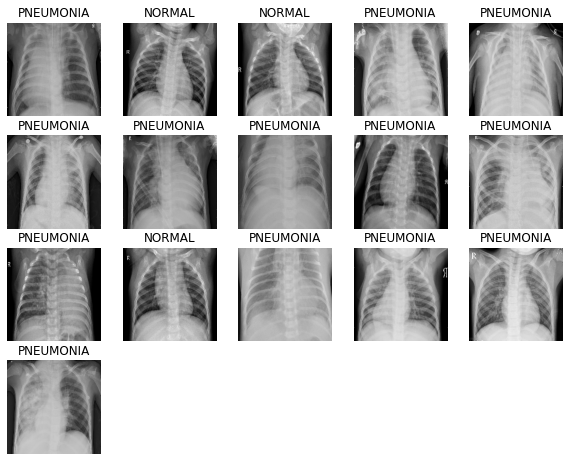

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

좌우 반전이 된 사진과 정상 사진이 랜덤하게 섞여 보입니다.

# 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
#Original model
def build_model_1():
    model_1 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model_1

In [19]:
#No_Dropout_model
def build_model_2():
    model_2 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
      # tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
      # tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model_2

In [20]:
#Dropout_0.5_model
def build_model_3():
    model_3 = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model_3

# 5. 데이터 imbalance 처리

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.93
Weight for class 1: 0.67


# 6. 모델 훈련

## 1. Original model

In [22]:
with tf.device('/GPU:0'):
    model_1 = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_1.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model_1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/25
261/261 [==============================] - 37s 143ms/step - loss: 0.4485 - accuracy: 0.7977 - precision: 0.9161 - recall: 0.8005 - val_loss: 0.6637 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 33s 126ms/step - loss: 0.2359 - accuracy: 0.9145 - precision: 0.9450 - recall: 0.9392 - val_loss: 0.9680 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 33s 127ms/step - loss: 0.1830 - accuracy: 0.9356 - precision: 0.9553 - recall: 0.9580 - val_loss: 0.4212 - val_accuracy: 0.7981 - val_precision: 0.7870 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1679 - accuracy: 0.9401 - precision: 0.9593 - recall: 0.9599 - val_loss: 0.4910 - val_accuracy: 0.7865 - val_precision: 0.7780 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 34s 129ms/step - loss: 0.1508 - accura

## 2. No_Dropout_model

In [24]:
with tf.device('/GPU:0'):
    model_2 = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history_2 = model_2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/25
261/261 [==============================] - 52s 200ms/step - loss: 0.3366 - accuracy: 0.8611 - precision: 0.9477 - recall: 0.8601 - val_loss: 0.7810 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 53s 203ms/step - loss: 0.1922 - accuracy: 0.9318 - precision: 0.9549 - recall: 0.9528 - val_loss: 1.0688 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1814 - accuracy: 0.9346 - precision: 0.9554 - recall: 0.9563 - val_loss: 0.4600 - val_accuracy: 0.7837 - val_precision: 0.7750 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1701 - accuracy: 0.9363 - precision: 0.9547 - recall: 0.9597 - val_loss: 0.0937 - val_accuracy: 0.9663 - val_precision: 0.9768 - val_recall: 0.9781
Epoch 5/25
261/261 [==============================] - 52s 200ms/step - loss: 0.1388 - accura

## 3. Dropout_0.5_model

In [26]:
with tf.device('/GPU:0'):
    model_3 = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_3.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):
    history_3 = model_3.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/25
261/261 [==============================] - 22s 84ms/step - loss: 0.5002 - accuracy: 0.7785 - precision: 0.8971 - recall: 0.7919 - val_loss: 0.7273 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 22s 84ms/step - loss: 0.2786 - accuracy: 0.8956 - precision: 0.9343 - recall: 0.9240 - val_loss: 1.1291 - val_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 87ms/step - loss: 0.2359 - accuracy: 0.9119 - precision: 0.9452 - recall: 0.9354 - val_loss: 0.9849 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 22s 85ms/step - loss: 0.2199 - accuracy: 0.9159 - precision: 0.9458 - recall: 0.9406 - val_loss: 0.6800 - val_accuracy: 0.7837 - val_precision: 0.7752 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 23s 86ms/step - loss: 0.1843 - accuracy: 0

# 7. 결과 확인과 시각화

테스트데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

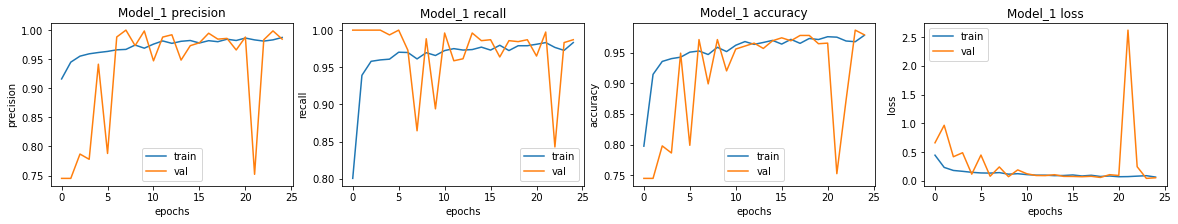

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model_1 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

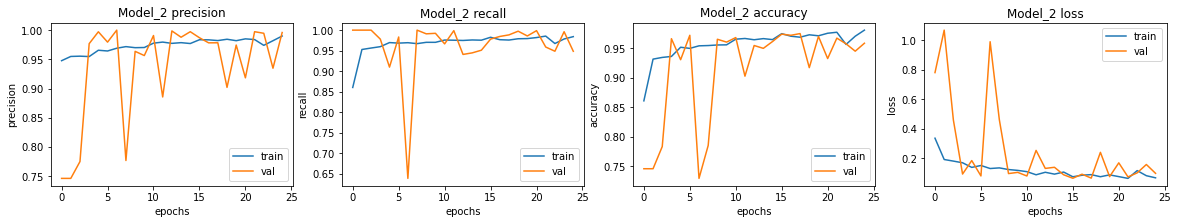

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_2.history[met])
    ax[i].plot(history_2.history['val_' + met])
    ax[i].set_title('Model_2 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

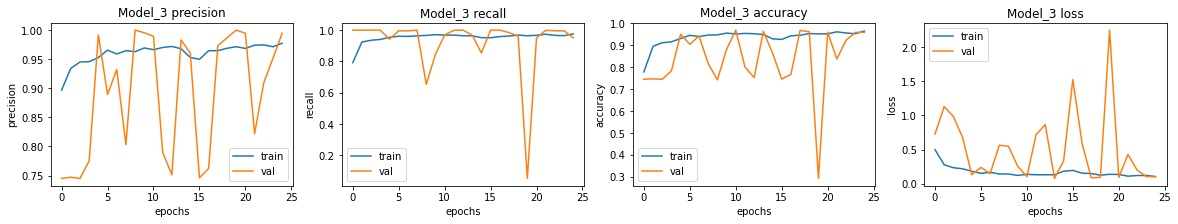

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_3.history[met])
    ax[i].plot(history_3.history['val_' + met])
    ax[i].set_title('Model_3 {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, acc, prec, rec = model_1.evaluate(test_ds)

39/39 [==============================] - 2s 59ms/step - loss: 1.1280 - accuracy: 0.7420 - precision: 0.7101 - recall: 0.9923


In [32]:
loss, acc, prec, rec = model_2.evaluate(test_ds)

39/39 [==============================] - 2s 58ms/step - loss: 0.6562 - accuracy: 0.8510 - precision: 0.8194 - recall: 0.9769


In [33]:
loss, acc, prec, rec = model_3.evaluate(test_ds)

39/39 [==============================] - 2s 58ms/step - loss: 0.6425 - accuracy: 0.8253 - precision: 0.7885 - recall: 0.9846


## 8. 루브릭 평가

1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.

모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.

regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.

3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.

Accuracy 기준 85%에 도달하였다.

## 9. 회고

- 의료영상을 처리할 때 이미지 자료의 습득이 부족할 수 있는데, 다양한 augmentation 방법 중 하나인 이미지를 반전 시키는 방법으로 정확도를 향상시킬 수 있었습니다.
- dropout 비율을 50%한 모델보다 dropout을 사용하지 않은 모델이 정확도가 더 높은데 학습하는 과정 중에 overfitting이 아직 되지 않은 것 같습니다.
- BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 사용하였는데 일반적으로 잘 사용되는 형태는 아니라고 합니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료영상에서는 간혹 좋은 성능을 보일 수도 있다는 정보를 새롭게 알게 되었습니다.